In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import cv2
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import ShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import Subset
import torchvision.transforms.functional as tf
import torch.optim as optim
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir(os.getcwd() + '/drive/MyDrive/CSGO_dataset')

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1YE5NVUqN6f8hUX8__fUuzwjXGB9GuAUP/CSGO_dataset'

In [ ]:
train = pd.read_csv(os.getcwd() + "/train/_annotations.csv")
valid = pd.read_csv(os.getcwd() + "/valid/_annotations.csv")
test = pd.read_csv(os.getcwd() + "/test/_annotations.csv")

In [ ]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1350_jpg.rf.18c2f5f32a04107ac6a65fca4cce508e.jpg,416,416,t,133,179,166,252
1,1350_jpg.rf.18c2f5f32a04107ac6a65fca4cce508e.jpg,416,416,thead,141,183,152,196
2,1350_jpg.rf.18c2f5f32a04107ac6a65fca4cce508e.jpg,416,416,thead,145,157,149,162
3,1350_jpg.rf.18c2f5f32a04107ac6a65fca4cce508e.jpg,416,416,thead,145,167,150,174
4,1350_jpg.rf.18c2f5f32a04107ac6a65fca4cce508e.jpg,416,416,t,140,156,154,173


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  8121 non-null   object
 1   width     8121 non-null   int64 
 2   height    8121 non-null   int64 
 3   class     8121 non-null   object
 4   xmin      8121 non-null   int64 
 5   ymin      8121 non-null   int64 
 6   xmax      8121 non-null   int64 
 7   ymax      8121 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 507.7+ KB


In [ ]:
train["filename"].nunique()

3306

In [ ]:
# train.drop(['class'], axis=1, inplace=True)
# valid.drop(['class'], axis=1, inplace=True)
# test.drop(['class'], axis=1, inplace=True)

In [ ]:
class_names = train['class'].unique().tolist()
class_names

['t', 'thead', 'ct', 'cthead']

In [ ]:
train['class'] = train['class'].map({class_name: i+1 for i, class_name in enumerate(class_names)})
valid['class'] = valid['class'].map({class_name: i+1 for i, class_name in enumerate(class_names)})
test['class'] = test['class'].map({class_name: i+1 for i, class_name in enumerate(class_names)})

In [ ]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1350_jpg.rf.18c2f5f32a04107ac6a65fca4cce508e.jpg,416,416,1,133,179,166,252
1,1350_jpg.rf.18c2f5f32a04107ac6a65fca4cce508e.jpg,416,416,2,141,183,152,196
2,1350_jpg.rf.18c2f5f32a04107ac6a65fca4cce508e.jpg,416,416,2,145,157,149,162
3,1350_jpg.rf.18c2f5f32a04107ac6a65fca4cce508e.jpg,416,416,2,145,167,150,174
4,1350_jpg.rf.18c2f5f32a04107ac6a65fca4cce508e.jpg,416,416,1,140,156,154,173


In [ ]:
train_dir= os.getcwd() + "/train"
valid_dir = os.getcwd() + "/valid"
test_dir= os.getcwd() + "/test"
model_weights_file="csgo_faster_rcnn.pth"

device="cuda" if torch.cuda.is_available() else "cpu"

batch_size=4
learning_rate=0.0001
epochs=30

threshold=0.5
iou_threshold=0.9

In [ ]:
"""The input to the model is expected to be a list of tensors, each of shape [C, H, W],
   one for each image, and should be in 0-1 range. Different images can have different
   sizes.The behavior of the model changes depending if it is in training or evaluation
   mode."""

class CustomDataset(Dataset):
    def __init__(self,dataframe,image_dir):
        super().__init__()
        self.dataframe=dataframe
        self.img_list=sorted(self.dataframe["filename"].unique())
        self.img_dir=image_dir

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=tf.to_tensor(img)

        inter=self.dataframe[self.dataframe["filename"]==self.img_list[idx]]
        boxes=inter[["xmin","ymin","xmax","ymax"]].values
        area= (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        labels=torch.tensor(inter["class"].values,dtype=torch.int64)
        iscrowd=torch.zeros((boxes.shape[0]),dtype=torch.uint8)

        target={}
        target["boxes"]=torch.as_tensor(boxes,dtype=torch.float32)
        target["area"]=torch.as_tensor(area,dtype=torch.float32)
        target["labels"]=labels
        target["iscrowd"]=iscrowd
        target["id"]=torch.tensor(idx)

        return img,target

In [ ]:
train_dataset = CustomDataset(train, train_dir)
valid_dataset = CustomDataset(valid, valid_dir)
test_dataset = CustomDataset(test, test_dir)

In [ ]:
def show(img,boxes,labels):
    boxes=boxes.detach().numpy().astype(np.int32)
    sample=img.permute(1,2,0).numpy().copy()

    for index in range(boxes.shape[0]):
        cv2.rectangle(sample,(boxes[index,0],boxes[index,1]),(boxes[index,2],boxes[index,3]),color=(0,255,0),thickness=1)
        cv2.putText(sample, class_names[labels[index]-1], (boxes[index,0],boxes[index,1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)


    plt.axis("off");
    plt.imshow(sample)
    plt.show()

In [ ]:
images, targets = next(iter(train_dataset))
targets

{'boxes': tensor([[133., 197., 226., 330.],
         [147., 204., 175., 220.]]),
 'area': tensor([12369.,   448.]),
 'labels': tensor([3, 4]),
 'iscrowd': tensor([0, 0], dtype=torch.uint8),
 'id': tensor(0)}

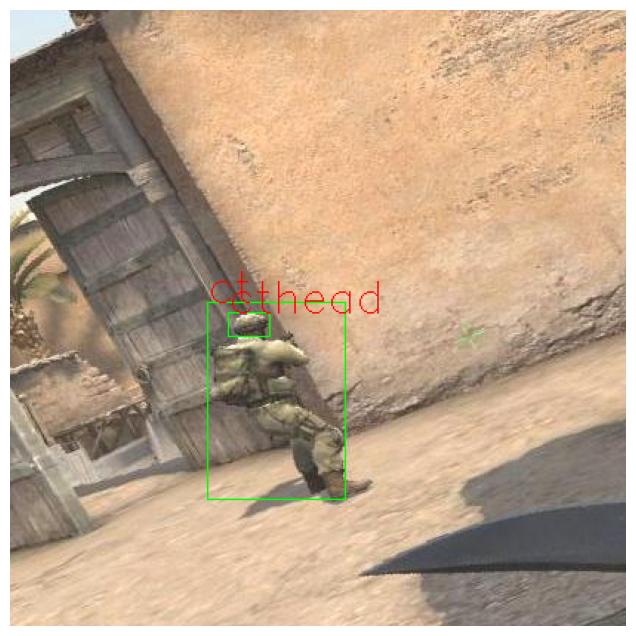

torch.Size([416, 416])

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,8))
show(images,targets["boxes"], targets["labels"])
plt.savefig("1.png")
images[0].shape

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dl=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2,
                    pin_memory=True if torch.cuda.is_available else False,
                    collate_fn=collate_fn)
val_dl=DataLoader(valid_dataset,batch_size=batch_size,shuffle=False,num_workers=2,
                  pin_memory=True if torch.cuda.is_available else False,
                  collate_fn=collate_fn)

In [ ]:
# load a model pre-trained on COCO
weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model=fasterrcnn_resnet50_fpn(weights=weights)

# replace the classifier with a new one, that has
# num_classes which is user-defined
# 1 class (person) + background
num_classes = 5

# get number of input features for the classifier
in_features=model.roi_heads.box_predictor.cls_score.in_features


# replace the pre-trained head with a new one
model.roi_heads.box_predictor=FastRCNNPredictor(in_channels=in_features,
                                                num_classes=num_classes)

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
for params in model.children():
    print(params)

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)
BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [ ]:
"""ConvNet as fixed feature extractor: Here, we will freeze the weights for the backbone of
   the network (resnet50 with feature pyramid network). The Regional Proposal network and
   Region of Interest heads will be fine tuned using transfer learning."""

classification_head=list(model.children())[-2:]

for children in list(model.children())[:-2]:
    for params in children.parameters():
        params.requires_grad=False

parameters=[]
for heads in classification_head:
    for params in heads.parameters():
        parameters.append(params)


optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=8, threshold=0.0001)


print(classification_head)

[RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
), RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=5, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=20, bias=True)
  )
)]


In [ ]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [ ]:
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):

    training_loss=0.0
    validation_loss=0.0
    current_lr=get_lr(optimizer)

    #During training, the model expects both the input tensors, as well as a targets
    model.train()
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

        """The model returns a Dict[Tensor] during training, containing the classification
           and regression losses for both the RPN and the R-CNN."""

        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

            """The model returns a Dict[Tensor] during training, containing the classification
               and regression losses for both the RPN and the R-CNN."""

            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()


    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)

    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")


    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)

    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

Updating Best Model weights

1/30
Training Loss: 0.08056255832035038
Validation_loss: 0.07948778475994712

**************************************************
Updating Best Model weights

2/30
Training Loss: 0.06105079381296798
Validation_loss: 0.07533617655923762

**************************************************

3/30
Training Loss: 0.053123346830200445
Validation_loss: 0.07665891214016757

**************************************************

4/30
Training Loss: 0.047336914873508995
Validation_loss: 0.07586134714217274

**************************************************

5/30
Training Loss: 0.04294607585495483
Validation_loss: 0.0758866683288586

**************************************************

6/30
Training Loss: 0.039483098815777266
Validation_loss: 0.0776557439446815

**************************************************

7/30
Training Loss: 0.03658129301100194
Validation_loss: 0.08085201941202023

**************************************************

8/30
Training Loss: 0.0341626148

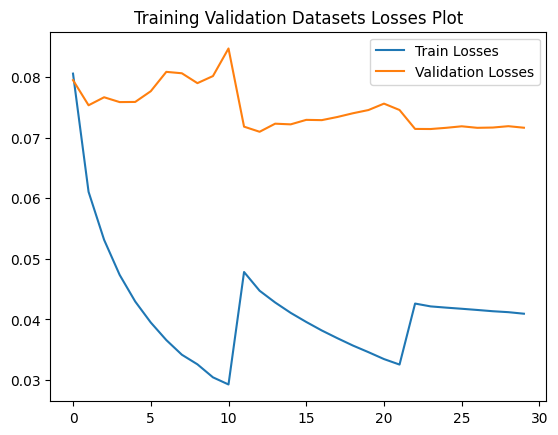

In [ ]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

In [ ]:
torch.save(best_weights,model_weights_file)

In [ ]:
model.load_state_dict(torch.load(model_weights_file))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
test_dl=DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2,
                  pin_memory=True if torch.cuda.is_available else False,
                  collate_fn=collate_fn)

In [ ]:
def show(img,boxes,labels,ax,color=(255,0,0)):
    boxes=boxes.detach().cpu().numpy().astype(np.int32)
    sample=img.permute(1,2,0).numpy().copy()

    for index in range(boxes.shape[0]):
        cv2.rectangle(sample,(boxes[index,0],boxes[index,1]),(boxes[index,2],boxes[index,3]),color=(0,255,0),thickness=2)
        cv2.putText(sample, class_names[labels[index]-1], (boxes[index,0],boxes[index,1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    ax.axis("off")
    ax.imshow(sample)

tensor([3, 4, 3], device='cuda:0')
tensor([3, 3], device='cuda:0')
tensor([1, 1, 2], device='cuda:0')
tensor([1], device='cuda:0')


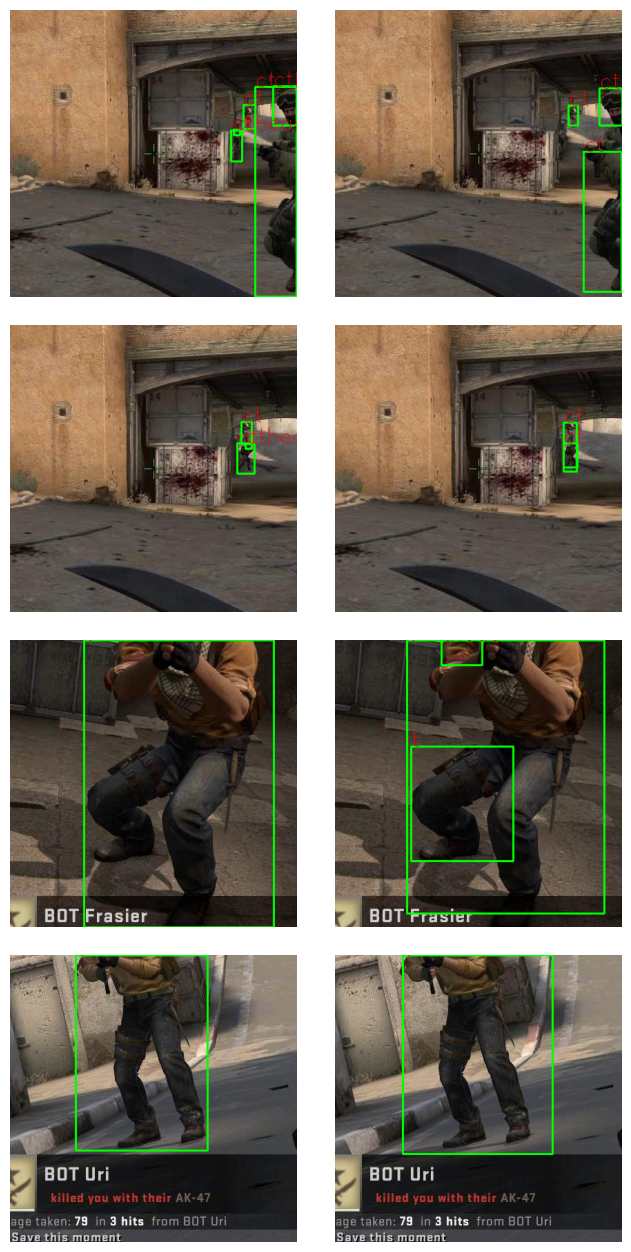

In [ ]:
"""During inference, the model requires only the input tensors, and returns the
   post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields
   of the Dict are as follows:
   - boxes (FloatTensor[N, 4]): the predicted boxes in [x0, y0, x1, y1] format
   - labels (Int64Tensor[N]): the predicted labels for each image
   - scores (Tensor[N]): the scores or each prediction"""

fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(test_dl))
model.eval()
output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    predictions=output[idx]

    #real bounding boxes
    show(img,targets[idx]["boxes"],targets[idx]["labels"],axes[i,0],color=(0,255,0))

    #non-max suppression
    threshold=0.5
    iou_threshold=0.7
    """Non-max suppression is the final step of these object detection algorithms and is
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""

    pp_boxes=predictions["boxes"][predictions["scores"]>=threshold]
    # print(pp_boxes)
    # print('-'*50)
    scores=predictions["scores"][predictions["scores"]>=threshold]
    # print(scores)
    # print('-'*50)
    pp_labels = predictions["labels"][predictions["scores"]>=threshold]
    nms=torchvision.ops.nms(pp_boxes,scores,iou_threshold=iou_threshold)
    # print(nms)
    # print('-'*50)
    pp_boxes=pp_boxes[nms]
    # print(pp_boxes)
    pp_labels = pp_labels[nms]
    print(pp_labels)


    show(img,pp_boxes,pp_labels,axes[i,1]);